In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import re
from scipy import stats


Set the visualization style

In [2]:

# Set visualisation style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [3]:

# Load datasets
transaction_data = pd.read_excel("C:\\Users\\CYBER SPACE\Desktop\\my_projects\\R\\Quantum Analysis\\QVI_transaction_data.xlsx")
customer_data = pd.read_csv("C:\\Users\\CYBER SPACE\\Desktop\\my_projects\\R\\Quantum Analysis\\QVI_purchase_behaviour.csv")

print("Transaction data shape:", transaction_data.shape)
print("Customer data shape:", customer_data.shape)

Transaction data shape: (264836, 8)
Customer data shape: (72637, 3)


The Transactional data contains 264836 rows, 8 Columns

The Customer data has 72637 rows of data and  3  columns

Let us First look at the transactional Data specifically

In [4]:
#preview data
print(transaction_data.head())
print('\n')
print(transaction_data.info())

    DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  43390          1            1000       1         5   
1  43599          1            1307     348        66   
2  43605          1            1343     383        61   
3  43329          2            2373     974        69   
4  43330          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  
0    Natural Chip        Compny SeaSalt175g         2        6.0  
1                  CCs Nacho Cheese    175g         3        6.3  
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9  
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0  
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   

The transactional dataset contains 8 columns `DATE` indicating the day at which the transaction occured,`STORE_NBR`, a number assigned to the store like an ID, `LYLTY_CARD_NBR`, Loyalty card for the customer they use to purchase goods, `TXN_ID`, Tax ID for the customer, `PROD_NBR` , `PROD_QTY`, an amount the of products a customer bought, `TOT_SALES`, and `PROD_NAME`

The `DATE` Column is not in proper date format,so we will first convert it

In [5]:
#Convert DATE to datetime
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin = '1899-12-30', unit='D')
print(transaction_data['DATE'].head(
    
))

0   2018-10-17
1   2019-05-14
2   2019-05-20
3   2018-08-17
4   2018-08-18
Name: DATE, dtype: datetime64[ns]


Examine PROD_NAME for Data Quality

In [6]:
#have a look at the PROD_NAME Column
transaction_data['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

We can observe that the PROD_NAME Does not favour us in anyway,its messed up with different categories and brands including sizes all joined together,therefore foe that reason we need to transform it

In [7]:
#Check Unique Product names
unique_prod_name = transaction_data['PROD_NAME'].nunique()
print(unique_prod_name)

114


In [8]:
#Extract words from product names
words = []
for name in transaction_data['PROD_NAME']:
    words.extend(re.findall(r'[A-Za-z&]+', name.lower()))

word_counts = pd.Series(words).value_counts()
print("Top 20 words in product names:")
print(word_counts.head(20))

Top 20 words in product names:
g           264836
chips        49770
kettle       41288
&            35565
smiths       28860
salt         27976
cheese       27890
pringles     25102
doritos      24962
crinkle      23960
corn         22063
original     21560
cut          20754
chip         18645
chicken      18577
salsa        18094
sea          14145
thins        14075
sour         13882
crisps       12607
Name: count, dtype: int64


### Remove non- chip products

In [9]:
#Identify salsa products
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.count('salsa')
print("Salsa products found:", transaction_data['SALSA'].sum())

Salsa products found: 18094


In [10]:
#Remove salsa products
transaction_data = transaction_data.loc[~transaction_data['SALSA'].astype(bool)].drop(columns=['SALSA'])
print("Shape after removing salsa:", transaction_data.shape)

Shape after removing salsa: (246742, 8)


### Check for Outliers and Nulls

In [11]:
#Summary
print(transaction_data.describe())

                                DATE      STORE_NBR  LYLTY_CARD_NBR  \
count                         246742  246742.000000    2.467420e+05   
mean   2018-12-30 01:19:01.211467520     135.051098    1.355310e+05   
min              2018-07-01 00:00:00       1.000000    1.000000e+03   
25%              2018-09-30 00:00:00      70.000000    7.001500e+04   
50%              2018-12-30 00:00:00     130.000000    1.303670e+05   
75%              2019-03-31 00:00:00     203.000000    2.030840e+05   
max              2019-06-30 00:00:00     272.000000    2.373711e+06   
std                              NaN      76.787096    8.071528e+04   

             TXN_ID       PROD_NBR       PROD_QTY      TOT_SALES  
count  2.467420e+05  246742.000000  246742.000000  246742.000000  
mean   1.351311e+05      56.351789       1.908062       7.321322  
min    1.000000e+00       1.000000       1.000000       1.700000  
25%    6.756925e+04      26.000000       2.000000       5.800000  
50%    1.351830e+05      

In [12]:
#Check for nulls
print("Nul counts:")
print(transaction_data.isnull().sum())

Nul counts:
DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64


There are no null values in the transactional data set

## Check for Outliers in the Dataset

In [13]:
#quantity outlier
outliers = transaction_data[transaction_data['PROD_QTY'] >= 200]
print("OutLier transactions:")
print(outliers)

OutLier transactions:
            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


We notice that there's one customers who's purchase counts is extremely far from the majority.We are going to verify this transaction by checking the Loyality cards

In [14]:
#Check customer's other transactions
loyalty_card = outliers['LYLTY_CARD_NBR'].values[0]
customer_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == loyalty_card]
print(customer_transactions)

            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                              PROD_NAME  PROD_QTY  TOT_SALES  
69762  Dorito Corn Chp     Supreme 380g       200      650.0  
69763  Dorito Corn Chp     Supreme 380g       200      650.0  


Still we confirm that its one customer.We are going to remove the customer

In [15]:
#Remove the Customer
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != loyalty_card]
print("Shape after removing outlier customer:", transaction_data.shape)

Shape after removing outlier customer: (246740, 8)


In [16]:
### Check for missing Dates
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name = 'N')
print("Number of uniue dates:", transactions_by_day)

Number of uniue dates:           DATE    N
0   2018-07-01  663
1   2018-07-02  650
2   2018-07-03  674
3   2018-07-04  669
4   2018-07-05  660
..         ...  ...
359 2019-06-26  657
360 2019-06-27  669
361 2019-06-28  673
362 2019-06-29  703
363 2019-06-30  704

[364 rows x 2 columns]


In [17]:
#Create full day range
date_range = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
date_df = pd.DataFrame({'DATE': date_range})
transactions_by_day = date_df.merge(transactions_by_day, on='DATE', how='left').fillna(0)

### Plot transactions over time

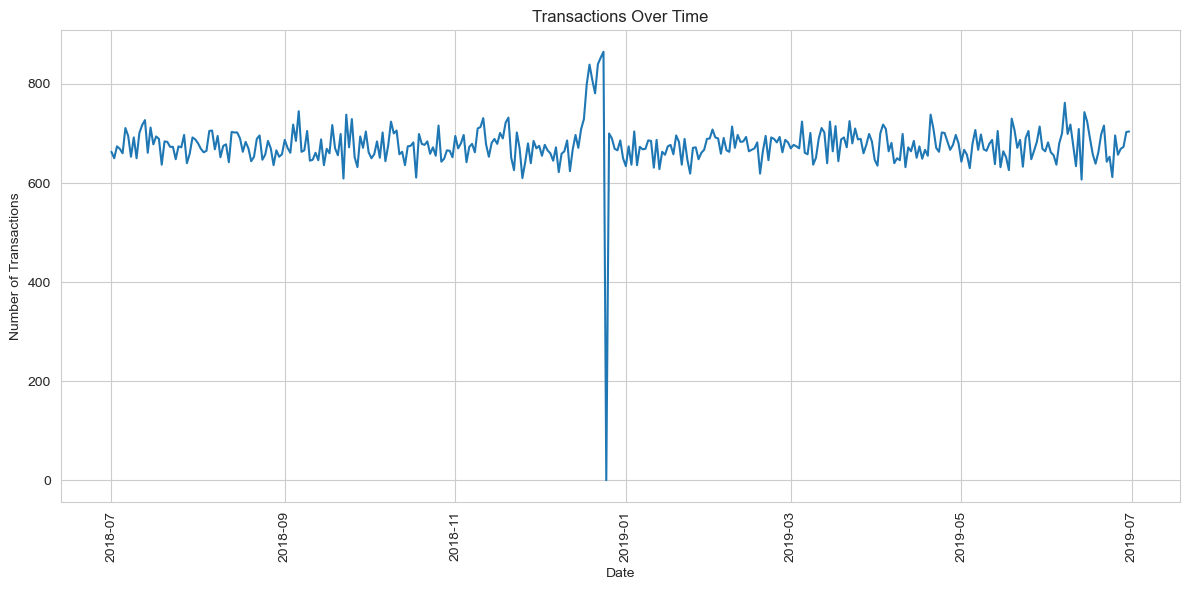

In [18]:
plt.Figure(figsize=(14,6))
plt.plot(transactions_by_day['DATE'], transactions_by_day['N'])
plt.title('Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The plot above shows the the transactions that occurred throughout the period 2018 JULY to 2019 JULY.But there's something that has captured our attention,we do observe that around December 2019 there were exponential fall in number of transactions to completely nothing.Let dive deep in the December transaction

### Dive deep into december 2018

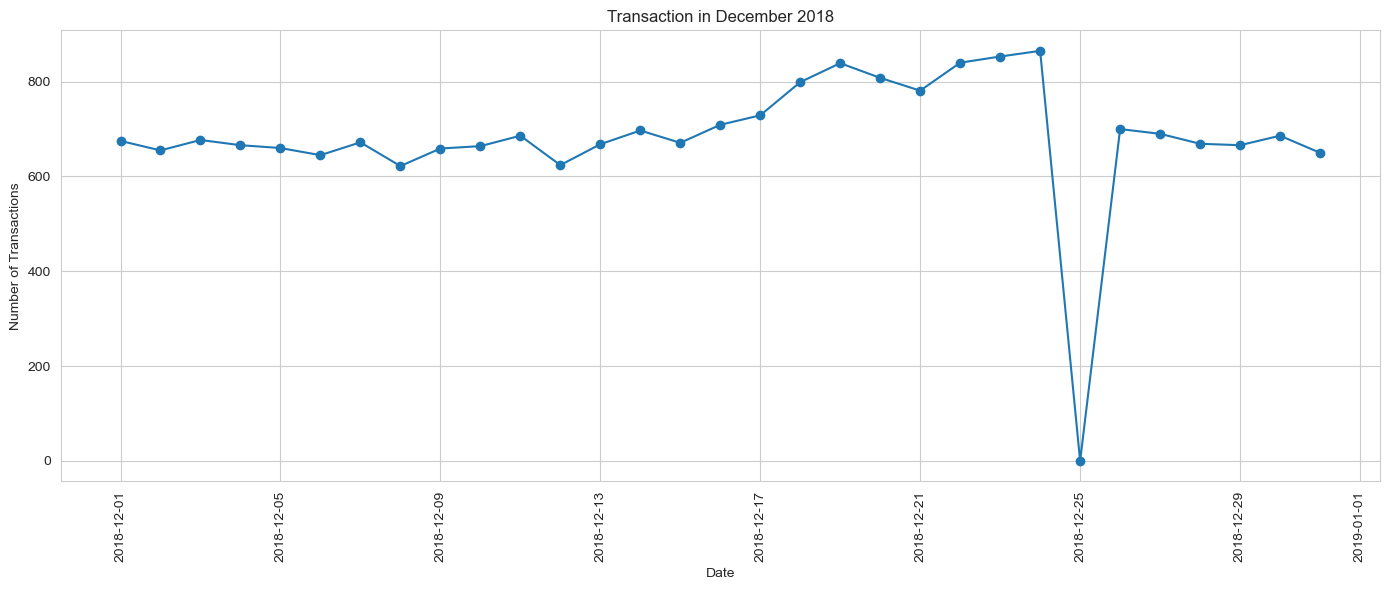

In [19]:
dec_data = transactions_by_day[(transactions_by_day['DATE'] >= '2018-12-01') & (transactions_by_day['DATE'] <= '2018-12-31')]

plt.figure(figsize=(14,6))
plt.plot(dec_data['DATE'], dec_data['N'], marker='o')
plt.title('Transaction in December 2018')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


To our notice, we can observe that the zero occured on 25th DEC of 2019,typically this might have been caused by the Christmas Holiday off Day 25th December,meaning that the shops either didn't operate or customers were engaged in christmas celebrations

### Extract pack size and brand

In [20]:
#Extract pack size (numeric part of PROD_NAME)
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(int)

#pack size distribution
print(transaction_data['PACK_SIZE'].value_counts().sort_index())

PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64


Let us visualize and check which Pack sizes were bought frequently

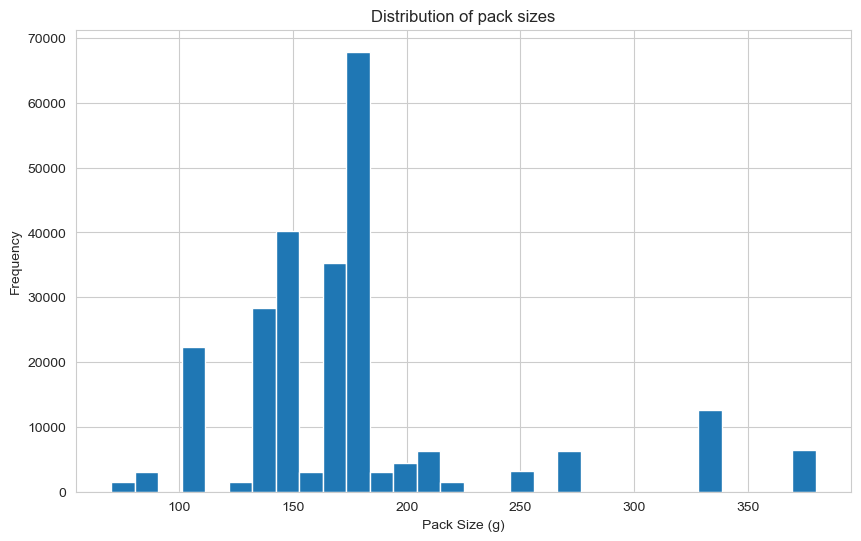

In [21]:
#Plot histogram
plt.figure(figsize=(10,6))
transaction_data['PACK_SIZE'].hist(bins=30)
plt.title('Distribution of pack sizes')
plt.xlabel('Pack Size (g)')
plt.ylabel('Frequency')
plt.show()

In [22]:
# Extract brand (first word in produt name)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].str.upper().str.split().str[0]
unique_brands = (transaction_data['BRAND'].unique())
unique_brands_df = pd.DataFrame(unique_brands, columns=['Brand Name']).sort_values(by='Brand Name')
print(unique_brands_df.reset_index(drop=True))


    Brand Name
0       BURGER
1          CCS
2      CHEETOS
3     CHEEZELS
4         COBS
5       DORITO
6      DORITOS
7       FRENCH
8        GRAIN
9      GRNWVES
10   INFUZIONS
11      INFZNS
12      KETTLE
13     NATURAL
14         NCC
15    PRINGLES
16         RED
17         RRD
18       SMITH
19      SMITHS
20       SNBTS
21    SUNBITES
22       THINS
23    TOSTITOS
24    TWISTIES
25    TYRRELLS
26  WOOLWORTHS
27          WW


In [23]:
brand_mapping = {
    "RED":"RRD",
    "SNBTS":"SUNBITES",
    "INFZNS":"INFUZIONS",
    "WW":"WOOLWORHTS",
    "SMITH":"SMITHS",
    "NCC":"NATURAL",
    "DORITO":"DORITOS",
    "GRNWVES":"GRAIN"
}

transaction_data['BRAND'] = transaction_data['BRAND'].replace(brand_mapping)
print('Number of Unique brands after cleaning:', transaction_data['BRAND'].unique())
print('\n')
print(f'Top 10 BRANDS:' ,transaction_data['BRAND'].value_counts().head(10))

Number of Unique brands after cleaning: ['NATURAL' 'CCS' 'SMITHS' 'KETTLE' 'GRAIN' 'DORITOS' 'TWISTIES'
 'WOOLWORHTS' 'THINS' 'BURGER' 'CHEEZELS' 'INFUZIONS' 'RRD' 'PRINGLES'
 'TYRRELLS' 'COBS' 'FRENCH' 'TOSTITOS' 'CHEETOS' 'WOOLWORTHS' 'SUNBITES']


Top 10 BRANDS: BRAND
KETTLE        41288
SMITHS        30353
DORITOS       25224
PRINGLES      25102
RRD           16321
INFUZIONS     14201
THINS         14075
WOOLWORHTS    10320
COBS           9693
TOSTITOS       9471
Name: count, dtype: int64


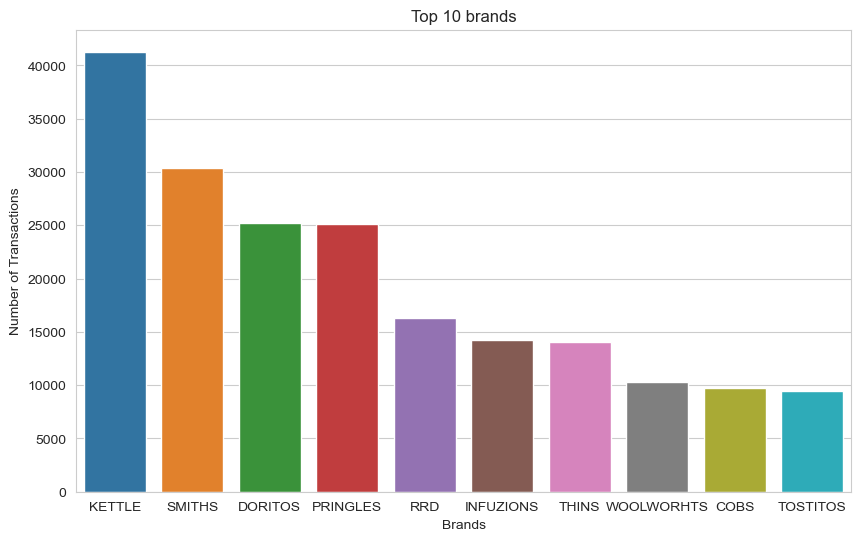

In [24]:
#VISUALIZE THE TOP 10 PRODUCTS
brand_summary = transaction_data['BRAND'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x = brand_summary.index, y = brand_summary.values, hue=brand_summary.index)
plt.title('Top 10 brands')
plt.xlabel('Brands')
plt.ylabel('Number of Transactions')
plt.show()

Let us visualize to see which brand had frequent transactions

## Merge Transaction and Customer Data

In [42]:
#Merge datasets
data = pd.merge(transaction_data, customer_data, on='LYLTY_CARD_NBR', how='left')
print("Merged data shape:", data.shape)

Merged data shape: (246740, 12)


In [43]:
#check for unmatched customers
print("Unmatched customers:", data['LIFESTAGE'].isnull().sum())

Unmatched customers: 0


In [44]:
#save the cleaned data
data.to_csv('QV1_clean_data.csv', index=False)
print("Cleaned data saved as 'QV1_clean_data'")

Cleaned data saved as 'QV1_clean_data'


## Customer segmentation Analysis

Relationship between BRAND and Premium Customer

In [45]:
#aggregate total sales by BRAND and PREMIUM_CUSTOMER
brand_vs_premium_customer = data.groupby(['BRAND', 'PREMIUM_CUSTOMER']).agg(
    total_sales = ('TOT_SALES', 'sum')
).reset_index()

In [46]:
#PIVOT FOR PLOTTING TO SHOW BRANDS
pv = brand_vs_premium_customer.pivot(index='BRAND', columns = 'PREMIUM_CUSTOMER', values='total_sales').fillna(0)
pv['total'] = pv.sum(axis=1)
pv = pv.sort_values(by='total', ascending=False)

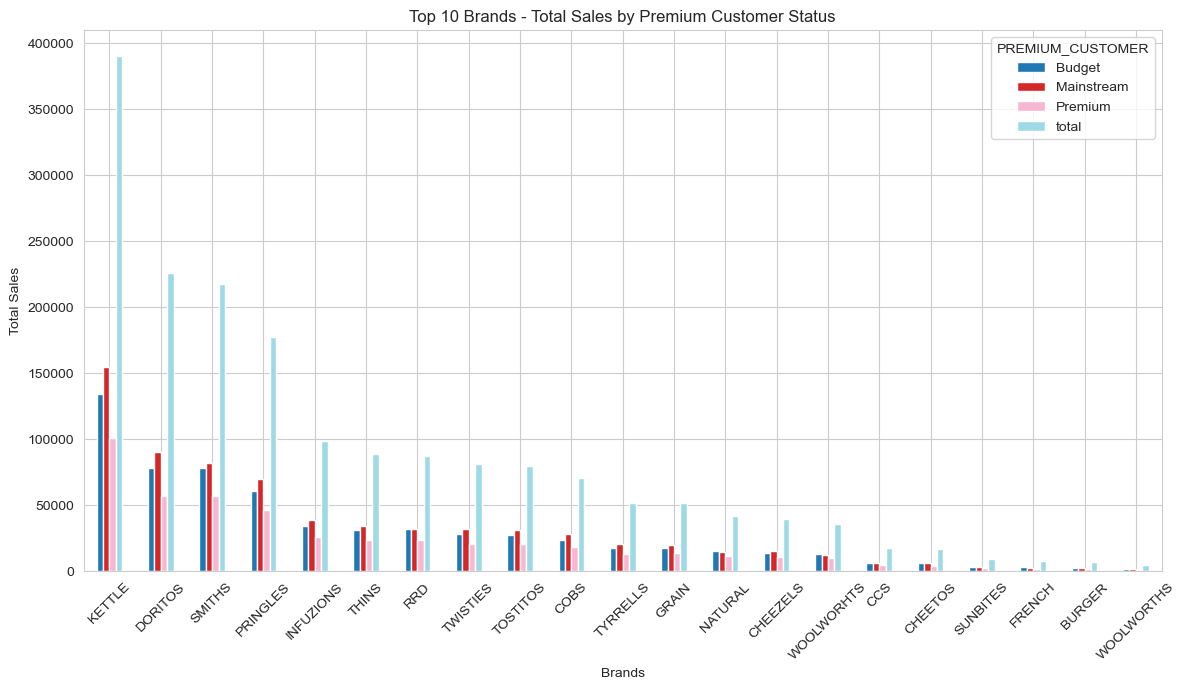

In [47]:
#Stacked bar of top 10 brands by premium customer status
pv.plot(kind='bar', stacked=False, figsize=(12,7), colormap='tab20')
plt.title('Top 10 Brands - Total Sales by Premium Customer Status')
plt.xlabel('Brands')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
#Total sales by Chip Category
chip_category_sales = data.groupby('BRAND').agg(
    total_sales = ('TOT_SALES', 'sum')
).reset_index()

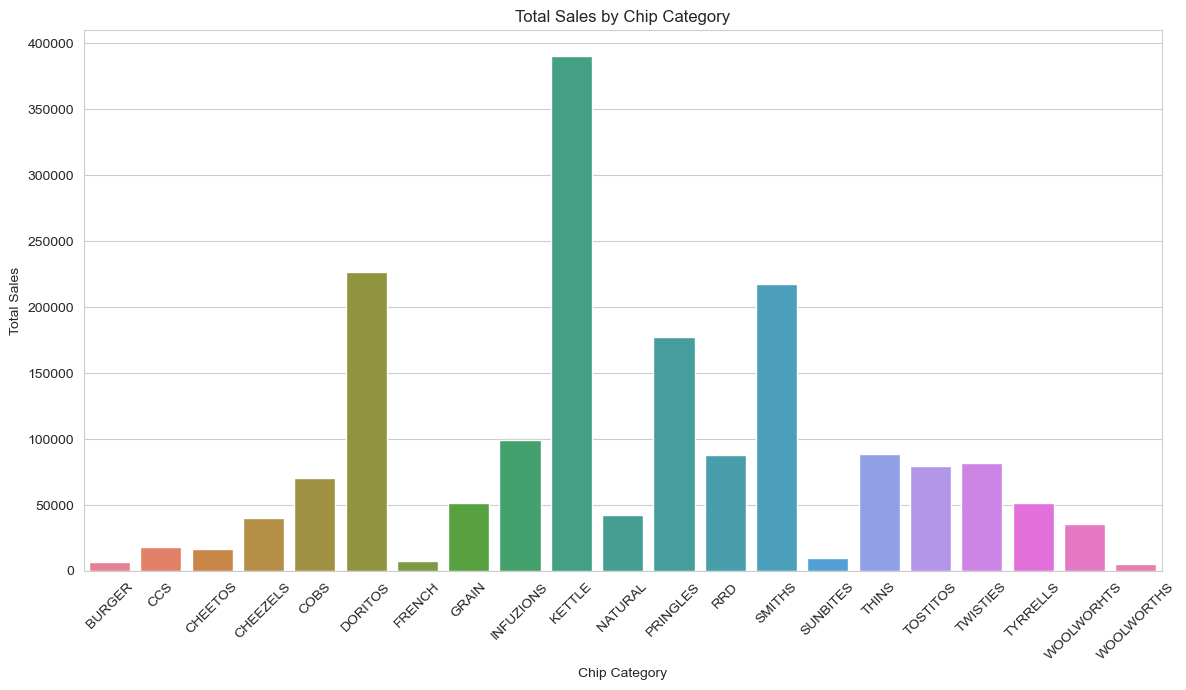

In [57]:
# visualize total sales by Chip Category
plt.figure(figsize=(12,7))
sns.barplot(data=chip_category_sales,x='BRAND', y='total_sales', hue='BRAND')
plt.title("Total Sales by Chip Category")
plt.xlabel("Chip Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Also let's try to see brand preference by LIFESTAGE

### Total sales by Lifestage and Premium customers


In [48]:
#Total sales by LIFESTAGE and PREMIUM CUSTOMER
sales_summary = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg(
    total_sales = ('TOT_SALES','sum'),
    customer_count = ('LYLTY_CARD_NBR', 'nunique')
).reset_index()

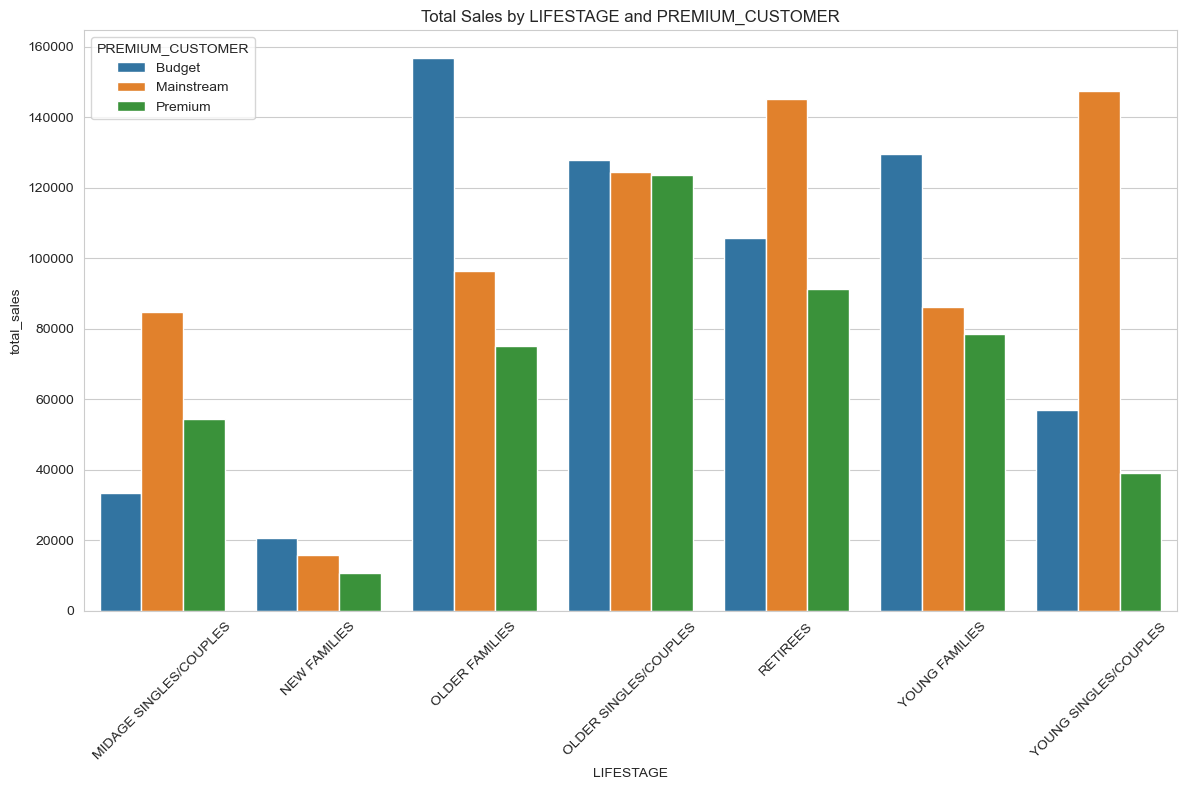

In [49]:
#Plot
plt.figure(figsize=(12,8))
sns.barplot(data=sales_summary, x = 'LIFESTAGE', y='total_sales', hue='PREMIUM_CUSTOMER')
plt.title('Total Sales by LIFESTAGE and PREMIUM_CUSTOMER')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We observe the budget group in the OLDER FAMILIES have more sales ,preceded by the mainstream premium customers from the Young Singles/Couples and the Retirees,The young families budget category is significantly contributing to sales,we shall dive deeper into this group in the next chapters

### Number of customers by segment

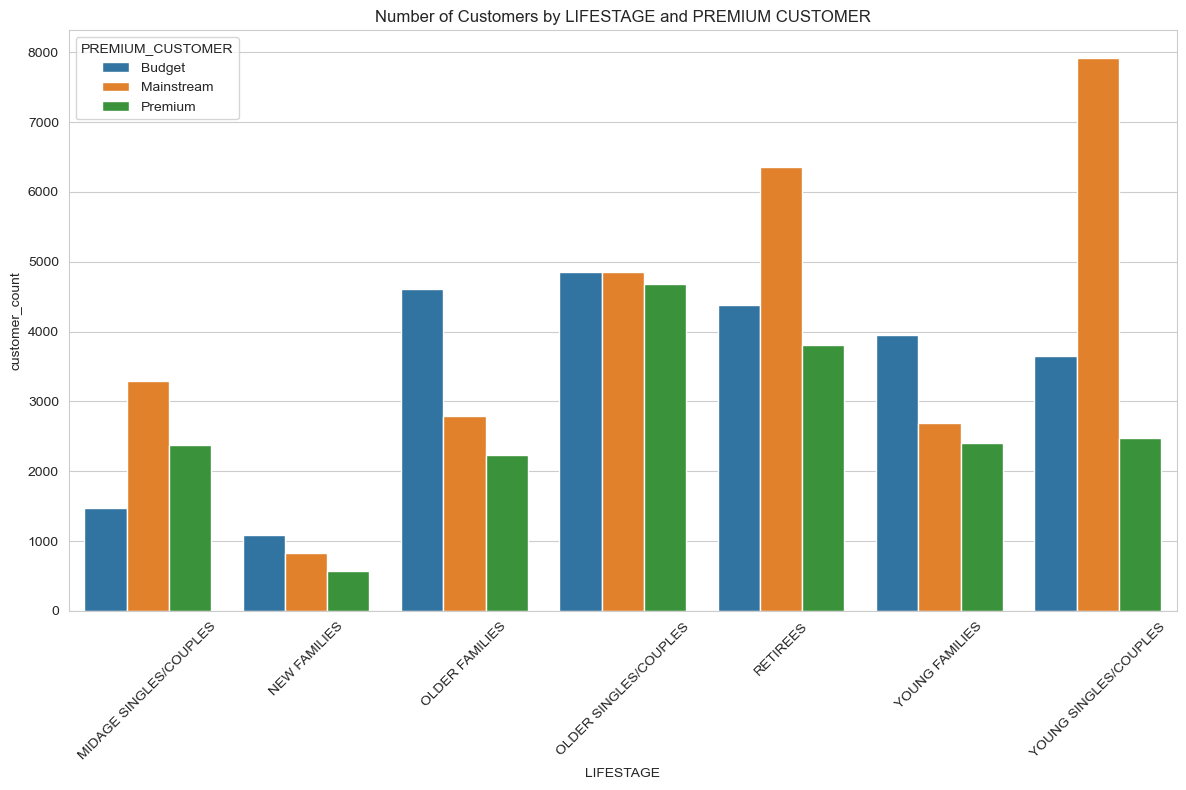

In [33]:
plt.figure(figsize=(12,8))
sns.barplot(data=sales_summary, x='LIFESTAGE', y='customer_count',hue='PREMIUM_CUSTOMER')
plt.title('Number of Customers by LIFESTAGE and PREMIUM CUSTOMER')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

There's something that has come to my understanding.From the previous chart the total sales by the budget group from the older families was way to big compared to the number of customers.That means the budget group spends alot or is over-charged leading to increased total sales from this group

### Average Units by customer

In [34]:
avg_units_per_cust = data.groupby(['LIFESTAGE','PREMIUM_CUSTOMER']).agg(
    avg_units = ('PROD_QTY', 'mean') 
).reset_index()

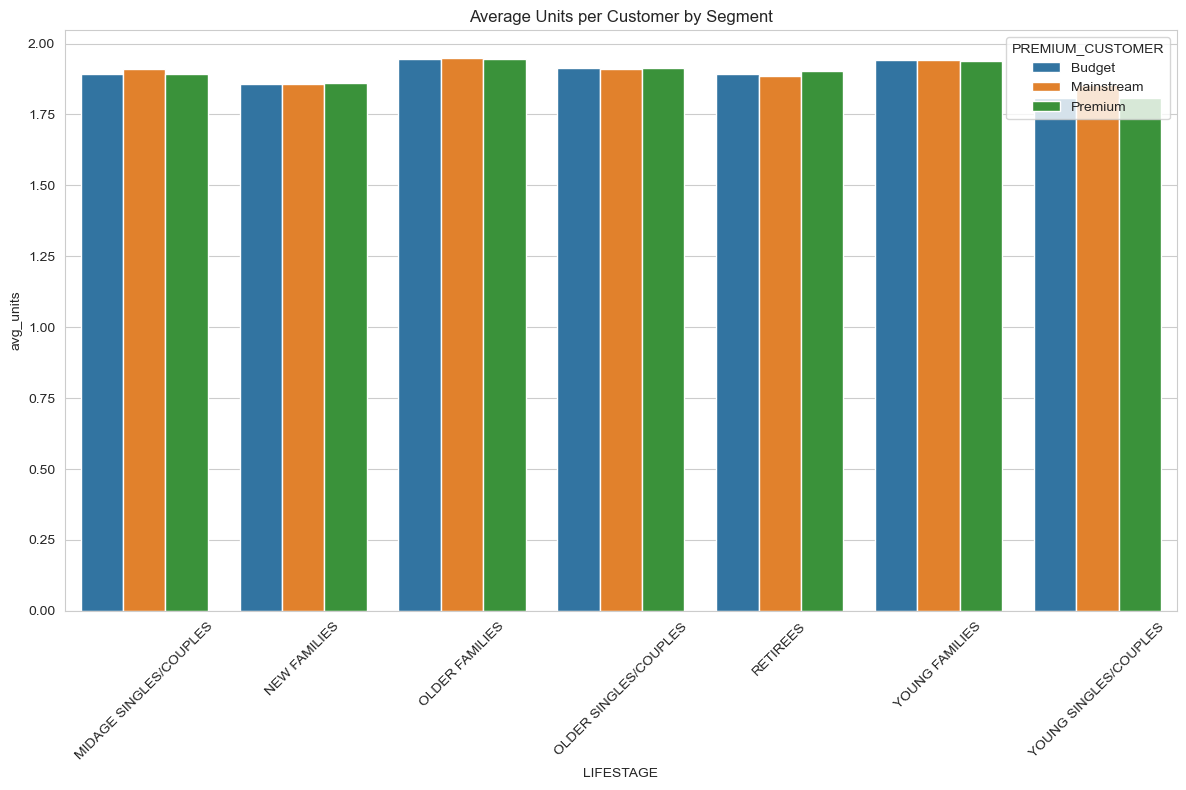

In [35]:
plt.figure(figsize=(12,8))
sns.barplot(data=avg_units_per_cust, x='LIFESTAGE', y='avg_units', hue='PREMIUM_CUSTOMER')
plt.title('Average Units per Customer by Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average price per unit

In [36]:
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
price_summary = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).agg(
    avg_price = ('PRICE_PER_UNIT','mean')

).reset_index()

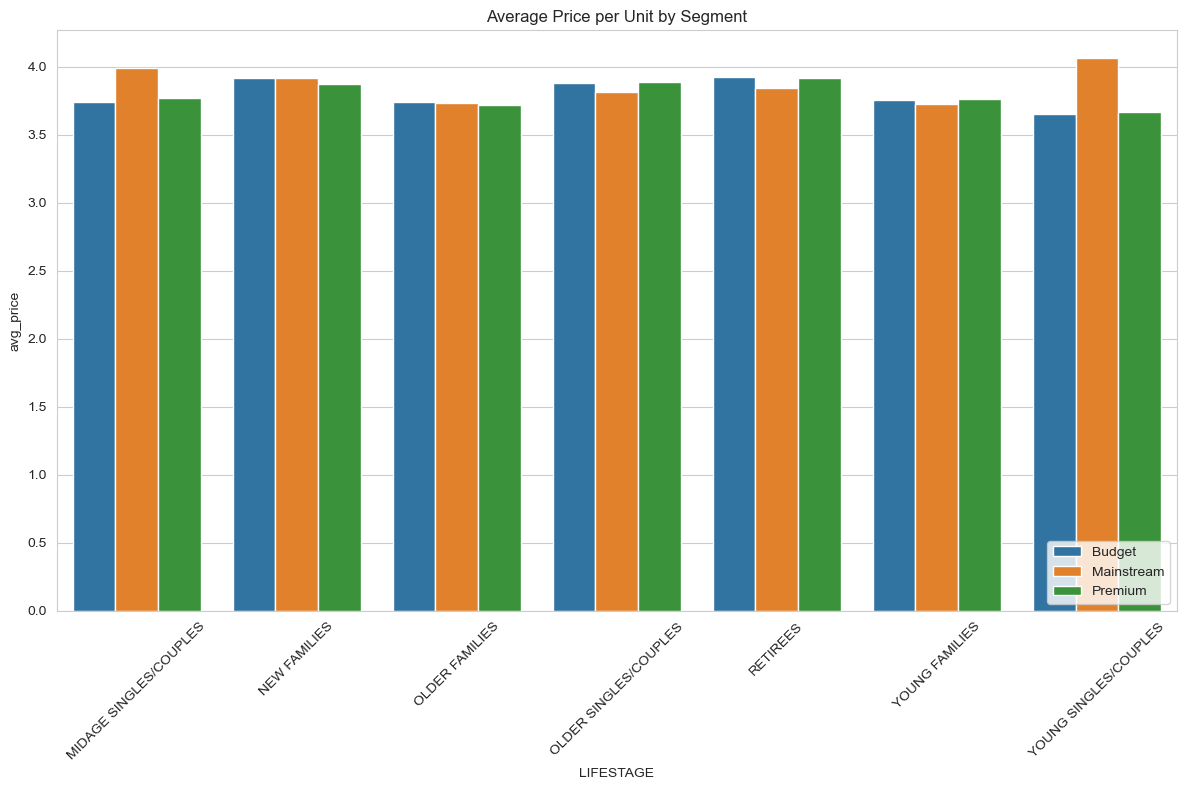

In [53]:
plt.figure(figsize=(12,8))
sns.barplot(data=price_summary, x='LIFESTAGE', y='avg_price', hue='PREMIUM_CUSTOMER')
plt.title('Average Price per Unit by Segment')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

We can observe that the Young singles/couples in the mainstream group and midage singles/couples are being charged more compared to other groups

### Statistical Test(t-test)

In [38]:
#compare mainstream vs premium/budget for young/mid-age singles/couples
segment_filter = (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES','MIDAGE SINGLES/COUPLES']))
mainstream = data[segment_filter & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]['PRICE_PER_UNIT']
budget_premium = data[segment_filter & (data['PREMIUM_CUSTOMER'].isin(['Budget','Premium']))]['PRICE_PER_UNIT']

In [39]:
#PERFORM T-TEST
t_stat, p_value = stats.ttest_ind(mainstream, budget_premium, equal_var=False)
print(f"T-statistics: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print('The unit price for mainstream young/mid-age singles/couples Is significantly different')
else:
    print("The unit price for mainstream young/mid-age singles/couples IS NOT significantly different")

T-statistics: 37.6244
P-value: 0.0000
The unit price for mainstream young/mid-age singles/couples Is significantly different


### Dive deep into Mainstream Young Singles/Couples

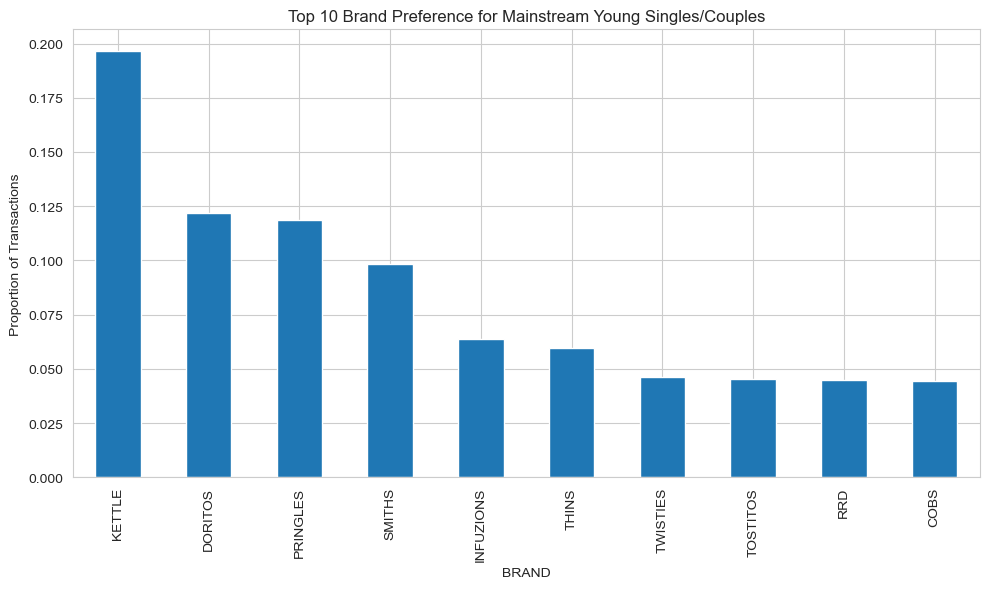

In [40]:
#Filter target segment
target_segments = data[(data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & (data['PREMIUM_CUSTOMER'] == 'Mainstream')]

#check brand preference
brand_pref = target_segments['BRAND'].value_counts(normalize=True).head(10)
plt.figure(figsize=(10,6))
brand_pref.plot(kind='bar')
plt.title('Top 10 Brand Preference for Mainstream Young Singles/Couples')
plt.ylabel('Proportion of Transactions')
plt.tight_layout()
plt.show()

These guys in the young singles/couples in the mainstream customer premium prefer KETTLE brand to others

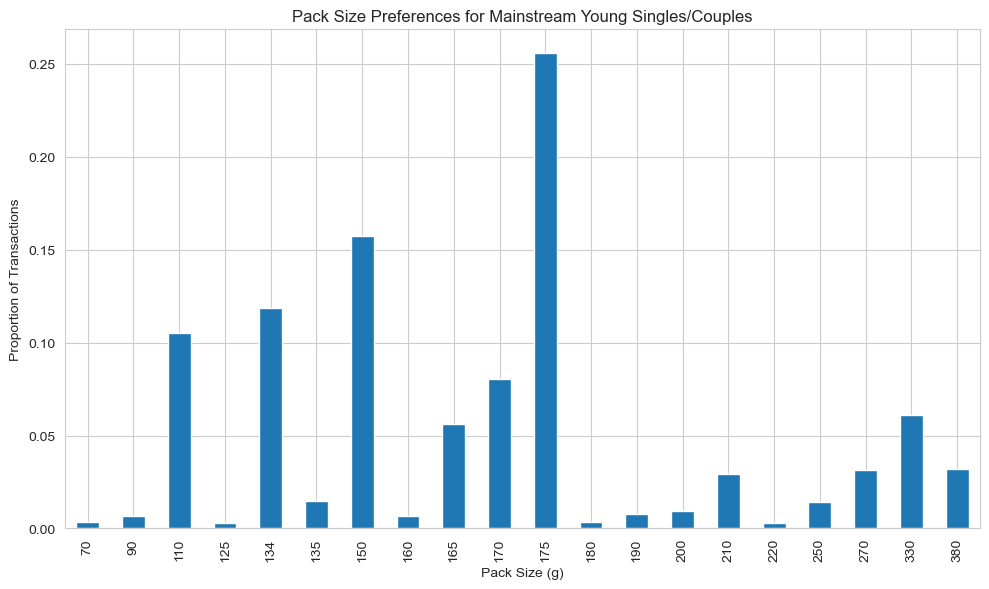

In [41]:
#pack size preference
pack_pref = target_segments['PACK_SIZE'].value_counts(normalize=True).sort_index()
plt.figure(figsize=(10,6))

pack_pref.plot(kind='bar')
plt.title('Pack Size Preferences for Mainstream Young Singles/Couples')
plt.xlabel('Pack Size (g)')
plt.ylabel('Proportion of Transactions')
plt.tight_layout()
plt.show()

## key Insights

- Young Singles/Couples and Retirees Contribute most to chip sales.This is most by the Mainstream premium customers
- Pack Sizes of 175 (g) and 150 (g) are the most bought sizes by customers
- There was a single customer who purchased over 200 pack sizes,we decided to remove him as he acted as an outlier 
- The Christmas Date had no transaction.
- Mainstream young singles prefer Kettle, Pringles and Doritos Brands more than others

## Div Deep Into New Families

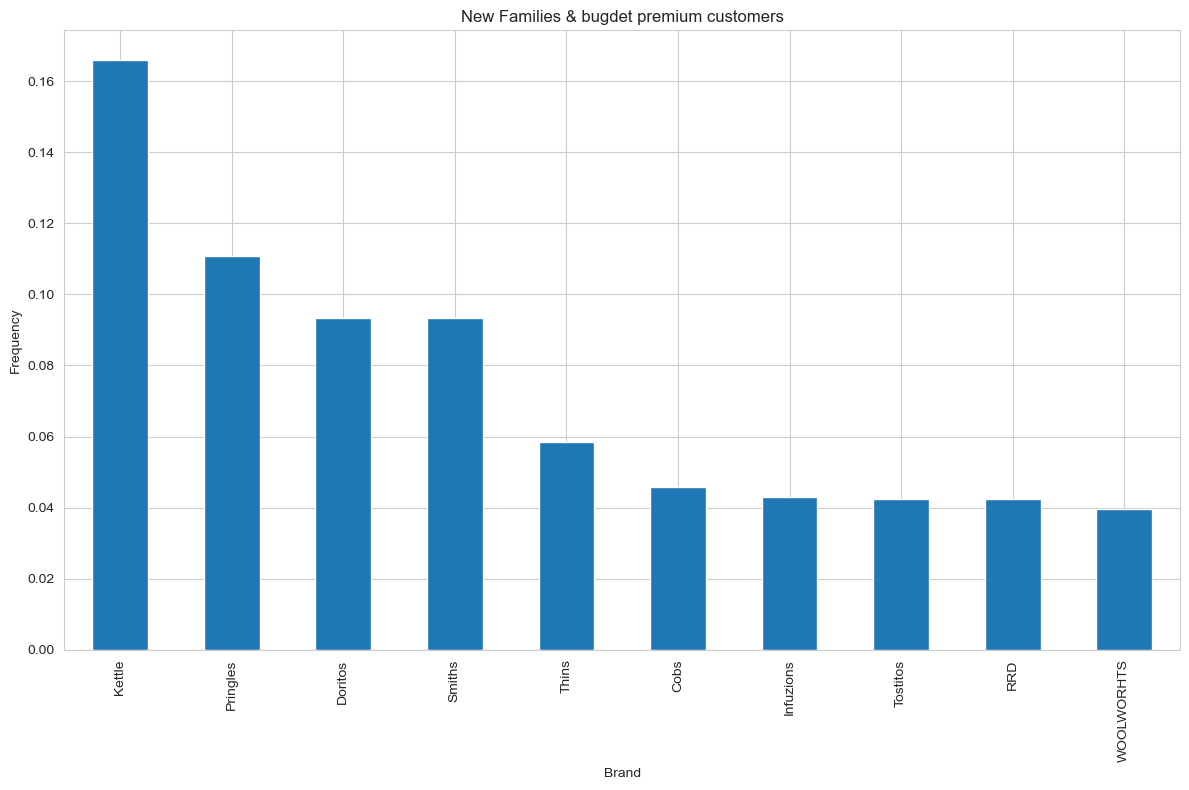

In [39]:
target_new_families = data[(data['LIFESTAGE'] == 'NEW FAMILIES') & (data['PREMIUM_CUSTOMER'] == 'Premium')]

#check there brand pref
brand_pred_new = target_new_families['BRAND'].value_counts(normalize=True).head(10)
plt.figure(figsize=(12,8))
brand_pred_new.plot(kind='bar')
plt.title('New Families & bugdet premium customers')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Pack Preference for the New Families

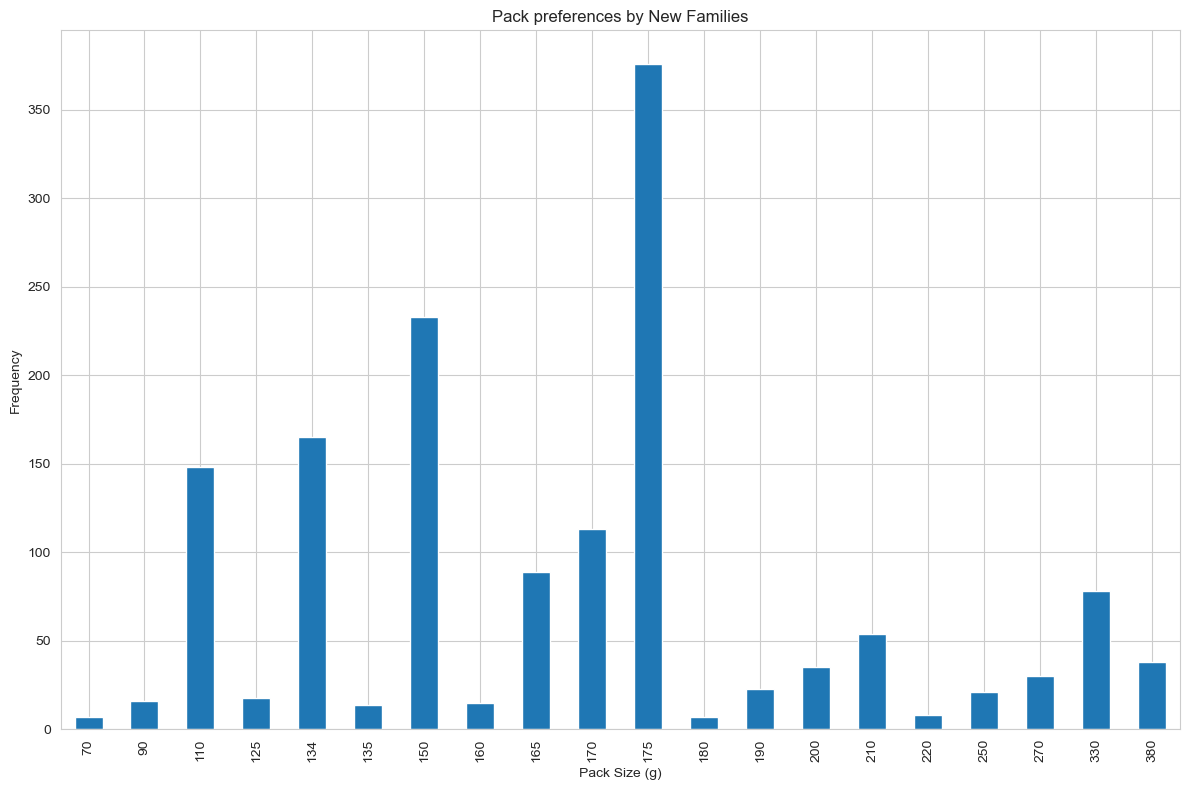

In [40]:
pack_pref_new_families = target_new_families['PACK_SIZE'].value_counts().sort_index()

plt.figure(figsize=(12,8))
pack_pref_new_families.plot(kind='bar')
plt.title('Pack preferences by New Families')
plt.xlabel('Pack Size (g)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()